# open mitgcm compressed binary outputs, show cube sphere tiling

---

In [1]:
import os, sys
import numpy as np

import xarray as xr
from matplotlib import pyplot as plt
%matplotlib inline

from mitequinox.utils import *
#from mitequinox.binary import *

from xmitgcm import llcreader
from fsspec.implementations.local import LocalFileSystem

In [ ]:
from dask.distributed import Client, LocalCluster
#
#cluster = LocalCluster()
#
from dask_jobqueue import PBSCluster
cluster = PBSCluster(processes=7, cores=7)
w = cluster.scale(jobs=2)
#
client = Client(cluster)
client

---

## load sea level data and plot it

In [6]:
v = 'Eta'

fs = LocalFileSystem()
store = llcreader.BaseStore(fs, base_path=bin_data_dir+v+'/', 
                            shrunk=True, mask_path=mask_path)
model = llcreader.LLC4320Model(store)

ds = model.get_dataset(varnames=[v])

In [7]:
ds

<xarray.Dataset>
Dimensions:  (face: 13, i: 4320, i_g: 4320, j: 4320, j_g: 4320, k: 90, k_l: 90, k_p1: 90, k_u: 90, time: 9030)
Coordinates:
  * face     (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
  * i        (i) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
  * i_g      (i_g) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
  * j        (j) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
  * j_g      (j_g) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
  * k        (k) int64 0 1 2 3 4 5 6 7 8 9 10 ... 80 81 82 83 84 85 86 87 88 89
  * k_u      (k_u) int64 0 1 2 3 4 5 6 7 8 9 ... 80 81 82 83 84 85 86 87 88 89
  * k_l      (k_l) int64 0 1 2 3 4 5 6 7 8 9 ... 80 81 82 83 84 85 86 87 88 89
  * k_p1     (k_p1) int64 0 1 2 3 4 5 6 7 8 9 ... 80 81 82 83 84 85 86 87 88 89
    niter    (time) int64 ...
  * time     (time) datetime64[ns] 2011-09-13 ... 2012-09-23T05:00:00
Data variables:
    Eta      (time, face, j, i) float32 dask.array<chunksize=(1, 3, 4320, 4320), meta=np.ndarray>

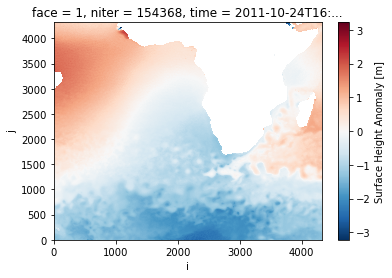

In [9]:
ds[v].isel(face=1,time=1000).plot()

---

## show faces

In [13]:
grd = xr.open_zarr(zarr_grid)

In [16]:
# store faces bounding boxes
r2d = 180./np.pi

faces = grd['face'].values
flon = dict()
flat = dict()
fcenter = dict()
for f in faces:
    flon[f] = np.array([grd['XC'].isel(face=f, i=i, j=j).values for i,j in zip([0,-1,-1,0],[0,0,-1,-1])])
    flat[f] = np.array([grd['YC'].isel(face=f, i=i, j=j).values for i,j in zip([0,-1,-1,0],[0,0,-1,-1])])
    v = np.array([0.,0.,0.])
    for lon, lat in zip(flon[f],flat[f]):
        #v += spherical2cartesian([np.cos(lon/r2d),0.,0.], lon/r2d, lat/r2d)
        v += [np.cos(lon/r2d)*np.cos(lat/r2d), np.sin(lon/r2d)*np.cos(lat/r2d), np.sin(lat/r2d)]
    v = v/np.sqrt(np.sum(v**2))
    fcenter[f] = [np.arctan2(v[1],v[0])*r2d , np.arcsin(v[2])*r2d]

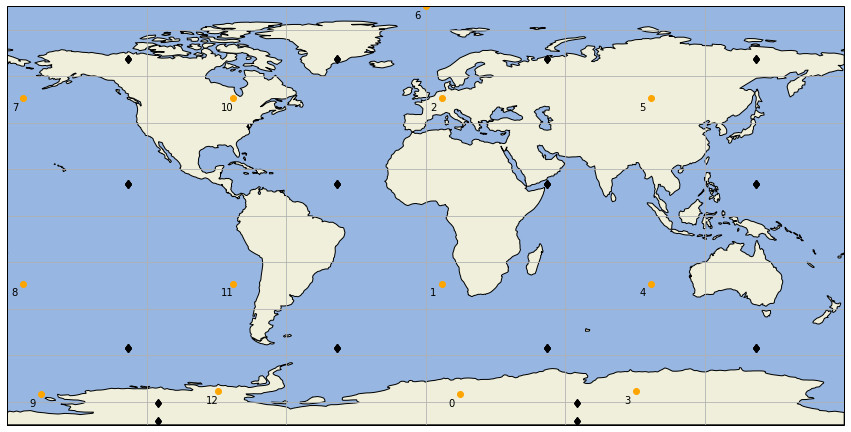

In [18]:
# plot faces on earth map
import cartopy.crs as ccrs
import cartopy.feature as cfeature

fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())

ax.add_feature(cfeature.OCEAN, zorder=0)
ax.add_feature(cfeature.LAND, zorder=0, edgecolor='black')
ax.set_global()
ax.gridlines()

for f in faces:
    ax.plot(flon[f],flat[f], 'd', color='k', transform=ccrs.PlateCarree())
    #
    ax.plot(fcenter[f][0], fcenter[f][1], 'o', color='orange', transform=ccrs.PlateCarree())
    ax.text(fcenter[f][0] - 5, fcenter[f][1] - 5, str(f), transform=ccrs.PlateCarree())